# ルールの時系列可視化分析
## 発見されたトップルールの時間軸(T)に沿った動作分析

In [1]:
import pandas as pd
import glob
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# 日本語フォント設定
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS', 'DejaVu Sans']
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams['figure.figsize'] = (16, 10)

# スタイル設定
sns.set_style("whitegrid")
sns.set_palette("husl")

print("Libraries loaded.")

Libraries loaded.


In [13]:
# データの読み込み
path = '../output/IB'
all_files = glob.glob(os.path.join(path, "*.txt"))

print(f"Loading {len(all_files)} files...")
all_dfs = []
for i, filename in enumerate(sorted(all_files)):
    df = pd.read_csv(filename, sep='\t')
    df['file_index'] = i
    df['file_name'] = os.path.basename(filename)
    all_dfs.append(df)

combined_df = pd.concat(all_dfs, ignore_index=True)
combined_df['Chi_squared'] = combined_df['Chi_squared'].fillna(0)

print(f"Total rules: {len(combined_df):,}")
print(f"Columns: {list(combined_df.columns)}")

Loading 48 files...
Total rules: 94,000
Columns: ['Attr1', 'Attr2', 'Attr3', 'Attr4', 'Attr5', 'Attr6', 'Attr7', 'Attr8', 'Actual_X_mean', 'Actual_X_sigma', 'X_mean', 'X_sigma', 'support_count', 'support_rate', 'HighSup', 'LowVar', 'Chi_squared', 'HighChi', 'NumAttr', 'DomMonth', 'DomQuarter', 'DomDay', 'TimeSpan', 'file_index', 'file_name']


In [15]:
# トップルールを特定
filtered_df = combined_df[
    (combined_df['support_rate'] >= 0.1) &
    ((combined_df['Chi_squared'] >= 3.84) | (combined_df['Chi_squared'] == 0))
].copy()

filtered_df['chi_bonus'] = 1 + filtered_df['Chi_squared'] / 10
filtered_df['score'] = (
    filtered_df['support_rate'] *
    filtered_df['support_count'] *
    filtered_df['chi_bonus']
)

filtered_df = filtered_df.sort_values(by='score', ascending=False)
filtered_df_unique = filtered_df.drop_duplicates(subset=['Attr1', 'Attr2', 'Attr3'], keep='first')

top_rule = filtered_df_unique.iloc[0]

print("="*80)
print("TOP RULE")
print("="*80)
print(f"Rule: {top_rule['Attr1']} & {top_rule['Attr2']} & {top_rule['Attr3']}")
print(f"Score: {top_rule['score']:.2f}")
print(f"Support Rate: {top_rule['support_rate']:.4f} ({top_rule['support_rate']*100:.2f}%)")
print(f"Mean Return (X): {top_rule['Actual_X_mean']:.4f}")
print(f"Std Dev: {top_rule['Actual_X_sigma']:.4f}")
print(f"Chi-squared: {top_rule['Chi_squared']:.3f}")
print("="*80)

TOP RULE
Rule: 9434_Stay(t-0) & 1333_Stay(t-4) & 7186_Stay(t-2)
Score: 5050.67
Support Rate: 0.7382 (73.82%)
Mean Return (X): 0.0320
Std Dev: 1.9070
Chi-squared: 7.611


In [20]:
# トップルールの全バリエーションを時系列で抽出
top_rule_data = combined_df[
    (combined_df['Attr1'] == top_rule['Attr1']) &
    (combined_df['Attr2'] == top_rule['Attr2'])
].copy()

# TimeSpanでソートして時間軸Tを作成
top_rule_data = top_rule_data.sort_values('TimeSpan').reset_index(drop=True)
top_rule_data['T'] = range(len(top_rule_data))

# 追加の指標を計算
top_rule_data['cumulative_return'] = (1 + top_rule_data['Actual_X_mean']).cumprod()
top_rule_data['benchmark_cumulative'] = (1 + top_rule_data['X_mean']).cumprod()
top_rule_data['excess_return'] = top_rule_data['Actual_X_mean'] - top_rule_data['X_mean']
top_rule_data['sharpe_ratio'] = top_rule_data['Actual_X_mean'] / (top_rule_data['Actual_X_sigma'] + 1e-6)

print(f"\nRule variations over time: {len(top_rule_data)}")
print(f"Time range: T=0 to T={len(top_rule_data)-1}")
print(f"TimeSpan range: {top_rule_data['TimeSpan'].min()} to {top_rule_data['TimeSpan'].max()} days")


Rule variations over time: 55
Time range: T=0 to T=54
TimeSpan range: 6434 to 7645 days


## グラフ1: 時間軸T vs リターンX（トップルールの基本動作）

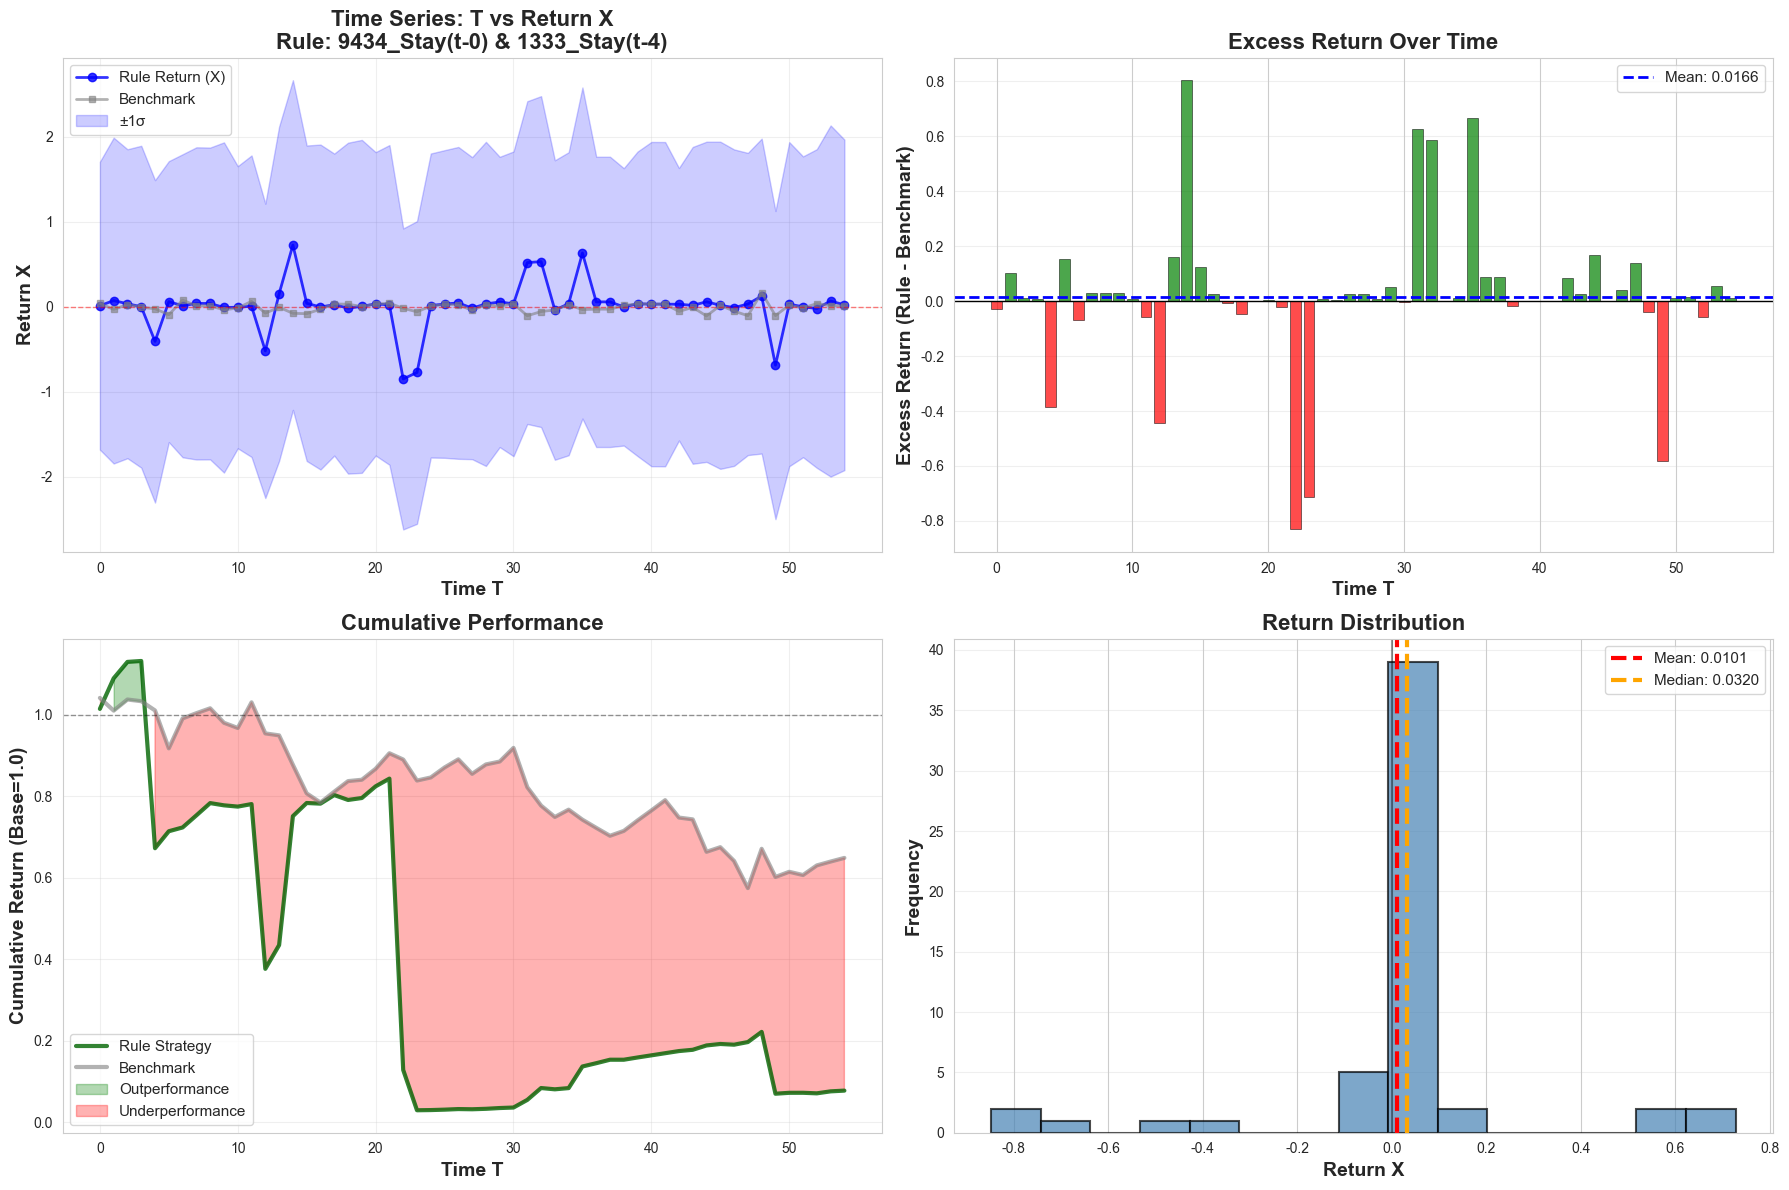


PERFORMANCE SUMMARY
Final Cumulative Return: 0.0774
Benchmark Cumulative Return: 0.6484
Total Outperformance: -0.5710
Win Rate (X > 0): 74.55%
Outperformance Rate: 65.45%


In [21]:
# グラフ1: T vs X（リターン）の基本可視化
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1-1: 実際のリターン vs 全体平均
axes[0, 0].plot(top_rule_data['T'], top_rule_data['Actual_X_mean'], 
                marker='o', linewidth=2, markersize=6, alpha=0.8, 
                label='Rule Return (X)', color='blue')
axes[0, 0].plot(top_rule_data['T'], top_rule_data['X_mean'], 
                marker='s', linewidth=2, markersize=4, alpha=0.6, 
                label='Benchmark', color='gray')
axes[0, 0].axhline(0, color='red', linestyle='--', alpha=0.5, linewidth=1)
axes[0, 0].fill_between(top_rule_data['T'], 
                        top_rule_data['Actual_X_mean'] - top_rule_data['Actual_X_sigma'],
                        top_rule_data['Actual_X_mean'] + top_rule_data['Actual_X_sigma'],
                        alpha=0.2, color='blue', label='±1σ')
axes[0, 0].set_xlabel('Time T', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Return X', fontsize=14, fontweight='bold')
axes[0, 0].set_title(f'Time Series: T vs Return X\nRule: {top_rule["Attr1"]} & {top_rule["Attr2"]}', 
                     fontsize=16, fontweight='bold')
axes[0, 0].legend(fontsize=11, loc='best')
axes[0, 0].grid(True, alpha=0.3)

# 1-2: 超過リターン（ルールの付加価値）
colors = ['green' if x > 0 else 'red' for x in top_rule_data['excess_return']]
axes[0, 1].bar(top_rule_data['T'], top_rule_data['excess_return'], 
               color=colors, alpha=0.7, edgecolor='black', linewidth=0.5)
axes[0, 1].axhline(0, color='black', linestyle='-', linewidth=1)
axes[0, 1].axhline(top_rule_data['excess_return'].mean(), 
                   color='blue', linestyle='--', linewidth=2, 
                   label=f"Mean: {top_rule_data['excess_return'].mean():.4f}")
axes[0, 1].set_xlabel('Time T', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Excess Return (Rule - Benchmark)', fontsize=14, fontweight='bold')
axes[0, 1].set_title('Excess Return Over Time', fontsize=16, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3, axis='y')

# 1-3: 累積リターン（投資成果）
axes[1, 0].plot(top_rule_data['T'], top_rule_data['cumulative_return'], 
                linewidth=3, label='Rule Strategy', color='darkgreen', alpha=0.8)
axes[1, 0].plot(top_rule_data['T'], top_rule_data['benchmark_cumulative'], 
                linewidth=3, label='Benchmark', color='gray', alpha=0.6)
axes[1, 0].axhline(1, color='black', linestyle='--', alpha=0.4, linewidth=1)
axes[1, 0].fill_between(top_rule_data['T'], 
                        top_rule_data['cumulative_return'], 
                        top_rule_data['benchmark_cumulative'],
                        where=(top_rule_data['cumulative_return'] >= top_rule_data['benchmark_cumulative']),
                        alpha=0.3, color='green', label='Outperformance')
axes[1, 0].fill_between(top_rule_data['T'], 
                        top_rule_data['cumulative_return'], 
                        top_rule_data['benchmark_cumulative'],
                        where=(top_rule_data['cumulative_return'] < top_rule_data['benchmark_cumulative']),
                        alpha=0.3, color='red', label='Underperformance')
axes[1, 0].set_xlabel('Time T', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Cumulative Return (Base=1.0)', fontsize=14, fontweight='bold')
axes[1, 0].set_title('Cumulative Performance', fontsize=16, fontweight='bold')
axes[1, 0].legend(fontsize=11, loc='best')
axes[1, 0].grid(True, alpha=0.3)

# 1-4: リターンの分布（ヒストグラム）
axes[1, 1].hist(top_rule_data['Actual_X_mean'], bins=15, 
                alpha=0.7, color='steelblue', edgecolor='black', linewidth=1.5)
axes[1, 1].axvline(top_rule_data['Actual_X_mean'].mean(), 
                   color='red', linestyle='--', linewidth=3, 
                   label=f"Mean: {top_rule_data['Actual_X_mean'].mean():.4f}")
axes[1, 1].axvline(top_rule_data['Actual_X_mean'].median(), 
                   color='orange', linestyle='--', linewidth=3, 
                   label=f"Median: {top_rule_data['Actual_X_mean'].median():.4f}")
axes[1, 1].axvline(0, color='black', linestyle='-', alpha=0.4)
axes[1, 1].set_xlabel('Return X', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Frequency', fontsize=14, fontweight='bold')
axes[1, 1].set_title('Return Distribution', fontsize=16, fontweight='bold')
axes[1, 1].legend(fontsize=11)
axes[1, 1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

# 統計サマリー
print("\n" + "="*80)
print("PERFORMANCE SUMMARY")
print("="*80)
print(f"Final Cumulative Return: {top_rule_data['cumulative_return'].iloc[-1]:.4f}")
print(f"Benchmark Cumulative Return: {top_rule_data['benchmark_cumulative'].iloc[-1]:.4f}")
print(f"Total Outperformance: {(top_rule_data['cumulative_return'].iloc[-1] - top_rule_data['benchmark_cumulative'].iloc[-1]):.4f}")
print(f"Win Rate (X > 0): {(top_rule_data['Actual_X_mean'] > 0).sum() / len(top_rule_data) * 100:.2f}%")
print(f"Outperformance Rate: {(top_rule_data['excess_return'] > 0).sum() / len(top_rule_data) * 100:.2f}%")

## グラフ2: ルールの信頼性指標の時系列変化

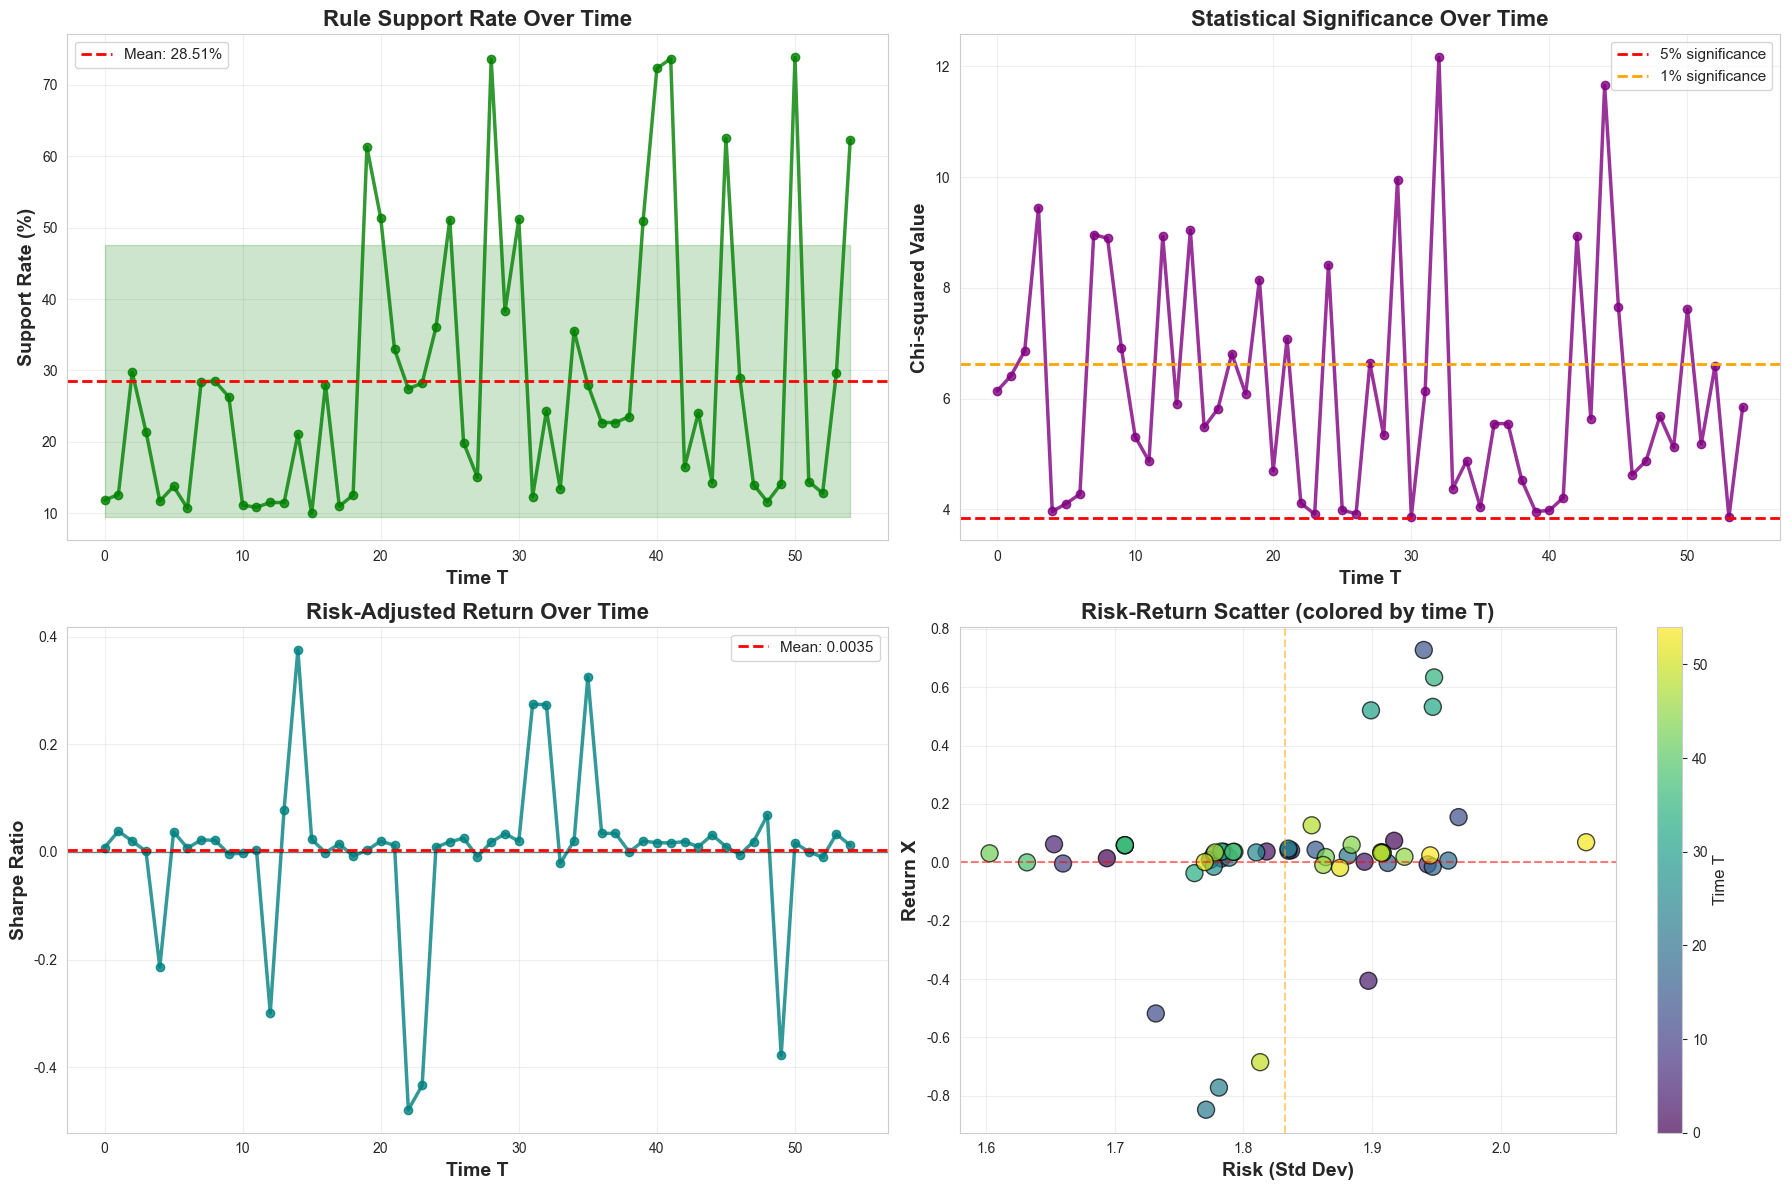

In [22]:
# グラフ2: ルールの品質指標の時系列
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 2-1: サポート率の変化
axes[0, 0].plot(top_rule_data['T'], top_rule_data['support_rate'] * 100, 
                marker='o', linewidth=2.5, markersize=6, color='green', alpha=0.8)
axes[0, 0].axhline(top_rule_data['support_rate'].mean() * 100, 
                   color='red', linestyle='--', linewidth=2, 
                   label=f"Mean: {top_rule_data['support_rate'].mean()*100:.2f}%")
axes[0, 0].fill_between(top_rule_data['T'], 
                        (top_rule_data['support_rate'].mean() - top_rule_data['support_rate'].std()) * 100,
                        (top_rule_data['support_rate'].mean() + top_rule_data['support_rate'].std()) * 100,
                        alpha=0.2, color='green')
axes[0, 0].set_xlabel('Time T', fontsize=14, fontweight='bold')
axes[0, 0].set_ylabel('Support Rate (%)', fontsize=14, fontweight='bold')
axes[0, 0].set_title('Rule Support Rate Over Time', fontsize=16, fontweight='bold')
axes[0, 0].legend(fontsize=11)
axes[0, 0].grid(True, alpha=0.3)

# 2-2: Chi-squared値の変化
axes[0, 1].plot(top_rule_data['T'], top_rule_data['Chi_squared'], 
                marker='o', linewidth=2.5, markersize=6, color='purple', alpha=0.8)
axes[0, 1].axhline(3.84, color='red', linestyle='--', linewidth=2, label='5% significance')
axes[0, 1].axhline(6.63, color='orange', linestyle='--', linewidth=2, label='1% significance')
axes[0, 1].set_xlabel('Time T', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Chi-squared Value', fontsize=14, fontweight='bold')
axes[0, 1].set_title('Statistical Significance Over Time', fontsize=16, fontweight='bold')
axes[0, 1].legend(fontsize=11)
axes[0, 1].grid(True, alpha=0.3)

# 2-3: シャープレシオの変化
axes[1, 0].plot(top_rule_data['T'], top_rule_data['sharpe_ratio'], 
                marker='o', linewidth=2.5, markersize=6, color='teal', alpha=0.8)
axes[1, 0].axhline(0, color='black', linestyle='-', linewidth=1, alpha=0.5)
axes[1, 0].axhline(top_rule_data['sharpe_ratio'].mean(), 
                   color='red', linestyle='--', linewidth=2, 
                   label=f"Mean: {top_rule_data['sharpe_ratio'].mean():.4f}")
axes[1, 0].set_xlabel('Time T', fontsize=14, fontweight='bold')
axes[1, 0].set_ylabel('Sharpe Ratio', fontsize=14, fontweight='bold')
axes[1, 0].set_title('Risk-Adjusted Return Over Time', fontsize=16, fontweight='bold')
axes[1, 0].legend(fontsize=11)
axes[1, 0].grid(True, alpha=0.3)

# 2-4: リターンとボラティリティの散布図（時間で色分け）
scatter = axes[1, 1].scatter(top_rule_data['Actual_X_sigma'], 
                            top_rule_data['Actual_X_mean'],
                            c=top_rule_data['T'], 
                            cmap='viridis', 
                            s=150, 
                            alpha=0.7, 
                            edgecolors='black', 
                            linewidth=1)
axes[1, 1].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].axvline(top_rule_data['Actual_X_sigma'].mean(), 
                   color='orange', linestyle='--', alpha=0.5)
axes[1, 1].set_xlabel('Risk (Std Dev)', fontsize=14, fontweight='bold')
axes[1, 1].set_ylabel('Return X', fontsize=14, fontweight='bold')
axes[1, 1].set_title('Risk-Return Scatter (colored by time T)', fontsize=16, fontweight='bold')
axes[1, 1].grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=axes[1, 1])
cbar.set_label('Time T', fontsize=12)

plt.tight_layout()
plt.show()

## グラフ3: ルールベースの取引シグナルと結果

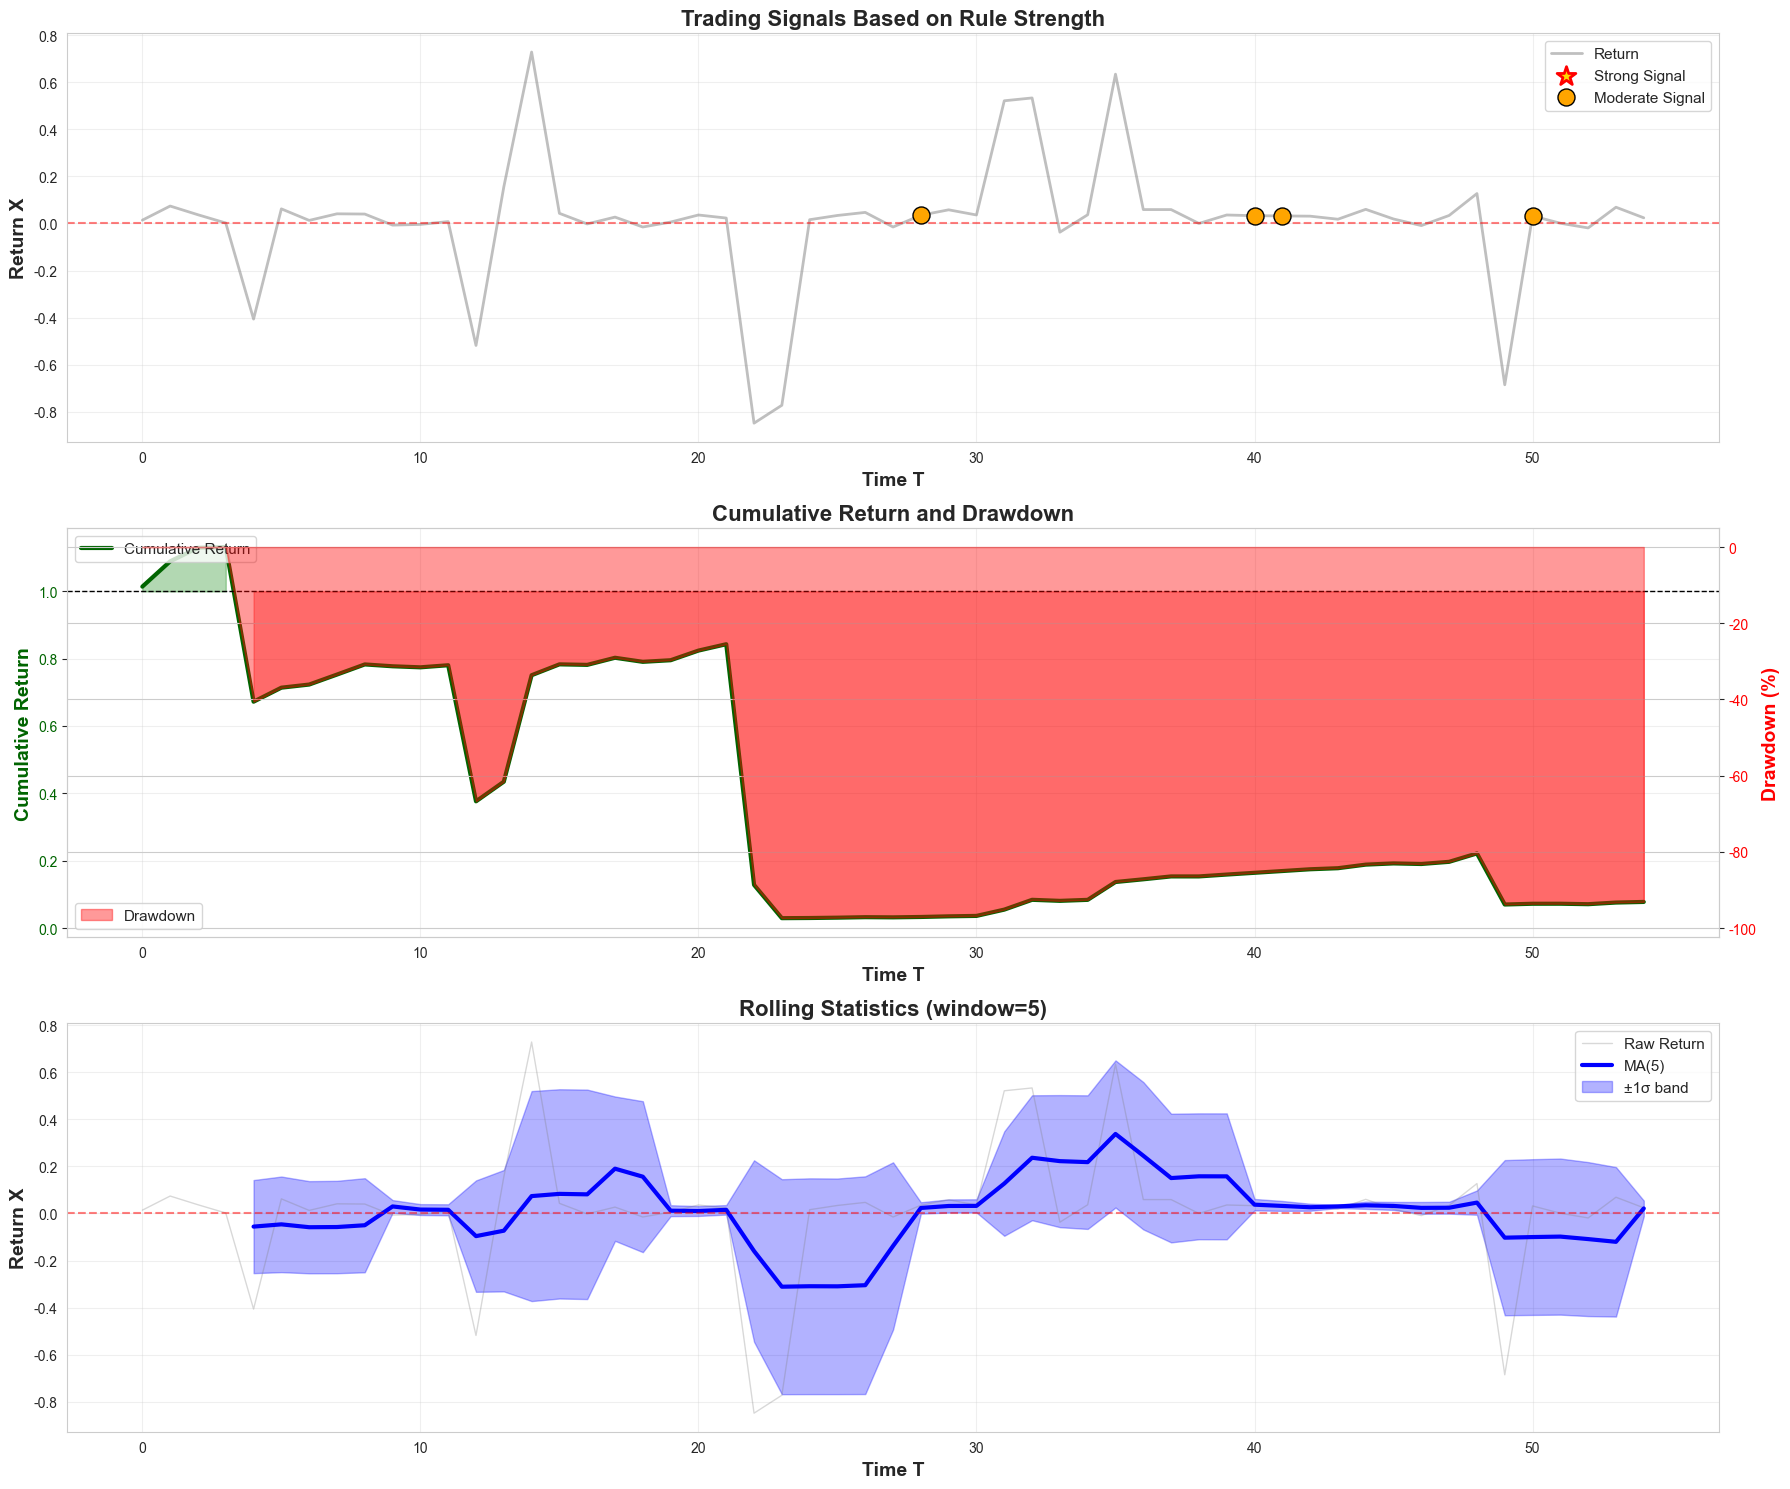


SIGNAL ANALYSIS
Strong Signals: 0 times
  Average Return: nan
  Win Rate: 0.00%

Moderate Signals: 4 times
  Average Return: 0.0330
  Win Rate: 100.00%

Maximum Drawdown: -97.42%


In [23]:
# グラフ3: 取引シグナルとパフォーマンス
fig, axes = plt.subplots(3, 1, figsize=(18, 15))

# 3-1: リターンと取引シグナル
# ルールが強く成立する（高Chi-squared & 高support）タイミングを強調
strong_signal = (top_rule_data['Chi_squared'] > 6.63) & (top_rule_data['support_rate'] > 0.8)
moderate_signal = (top_rule_data['Chi_squared'] > 3.84) & (top_rule_data['support_rate'] > 0.7) & ~strong_signal

axes[0].plot(top_rule_data['T'], top_rule_data['Actual_X_mean'], 
             linewidth=2, color='gray', alpha=0.5, label='Return')
axes[0].scatter(top_rule_data[strong_signal]['T'], 
                top_rule_data[strong_signal]['Actual_X_mean'],
                s=200, marker='*', color='gold', edgecolors='red', 
                linewidth=2, label='Strong Signal', zorder=5)
axes[0].scatter(top_rule_data[moderate_signal]['T'], 
                top_rule_data[moderate_signal]['Actual_X_mean'],
                s=150, marker='o', color='orange', edgecolors='black', 
                linewidth=1, label='Moderate Signal', zorder=4)
axes[0].axhline(0, color='red', linestyle='--', alpha=0.5)
axes[0].set_xlabel('Time T', fontsize=14, fontweight='bold')
axes[0].set_ylabel('Return X', fontsize=14, fontweight='bold')
axes[0].set_title('Trading Signals Based on Rule Strength', fontsize=16, fontweight='bold')
axes[0].legend(fontsize=11, loc='best')
axes[0].grid(True, alpha=0.3)

# 3-2: 累積リターンとドローダウン
cumulative = top_rule_data['cumulative_return']
running_max = cumulative.cummax()
drawdown = (cumulative - running_max) / running_max * 100

ax2 = axes[1]
ax2.plot(top_rule_data['T'], cumulative, 
         linewidth=3, color='darkgreen', label='Cumulative Return')
ax2.fill_between(top_rule_data['T'], 1, cumulative, 
                 where=(cumulative >= 1), alpha=0.3, color='green')
ax2.fill_between(top_rule_data['T'], 1, cumulative, 
                 where=(cumulative < 1), alpha=0.3, color='red')
ax2.axhline(1, color='black', linestyle='--', linewidth=1)
ax2.set_xlabel('Time T', fontsize=14, fontweight='bold')
ax2.set_ylabel('Cumulative Return', fontsize=14, fontweight='bold', color='darkgreen')
ax2.tick_params(axis='y', labelcolor='darkgreen')
ax2.grid(True, alpha=0.3)

# ドローダウンを第2軸に
ax2_twin = ax2.twinx()
ax2_twin.fill_between(top_rule_data['T'], 0, drawdown, 
                      color='red', alpha=0.4, label='Drawdown')
ax2_twin.set_ylabel('Drawdown (%)', fontsize=14, fontweight='bold', color='red')
ax2_twin.tick_params(axis='y', labelcolor='red')

ax2.set_title('Cumulative Return and Drawdown', fontsize=16, fontweight='bold')
ax2.legend(loc='upper left', fontsize=11)
ax2_twin.legend(loc='lower left', fontsize=11)

# 3-3: リターンのローリング統計
window = min(5, len(top_rule_data) // 3)
if window >= 2:
    rolling_mean = top_rule_data['Actual_X_mean'].rolling(window=window).mean()
    rolling_std = top_rule_data['Actual_X_mean'].rolling(window=window).std()
    
    axes[2].plot(top_rule_data['T'], top_rule_data['Actual_X_mean'], 
                 alpha=0.3, linewidth=1, color='gray', label='Raw Return')
    axes[2].plot(top_rule_data['T'], rolling_mean, 
                 linewidth=3, color='blue', label=f'MA({window})')
    axes[2].fill_between(top_rule_data['T'], 
                        rolling_mean - rolling_std,
                        rolling_mean + rolling_std,
                        alpha=0.3, color='blue', label='±1σ band')
    axes[2].axhline(0, color='red', linestyle='--', alpha=0.5)
    axes[2].set_xlabel('Time T', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Return X', fontsize=14, fontweight='bold')
    axes[2].set_title(f'Rolling Statistics (window={window})', fontsize=16, fontweight='bold')
    axes[2].legend(fontsize=11, loc='best')
    axes[2].grid(True, alpha=0.3)
else:
    axes[2].text(0.5, 0.5, 'Insufficient data for rolling statistics', 
                ha='center', va='center', transform=axes[2].transAxes, fontsize=14)
    axes[2].axis('off')

plt.tight_layout()
plt.show()

# シグナル統計
print("\n" + "="*80)
print("SIGNAL ANALYSIS")
print("="*80)
print(f"Strong Signals: {strong_signal.sum()} times")
print(f"  Average Return: {top_rule_data[strong_signal]['Actual_X_mean'].mean():.4f}")
print(f"  Win Rate: {(top_rule_data[strong_signal]['Actual_X_mean'] > 0).sum() / max(strong_signal.sum(), 1) * 100:.2f}%")
print(f"\nModerate Signals: {moderate_signal.sum()} times")
print(f"  Average Return: {top_rule_data[moderate_signal]['Actual_X_mean'].mean():.4f}")
print(f"  Win Rate: {(top_rule_data[moderate_signal]['Actual_X_mean'] > 0).sum() / max(moderate_signal.sum(), 1) * 100:.2f}%")
print(f"\nMaximum Drawdown: {drawdown.min():.2f}%")

## グラフ4: 多次元分析（T, X, その他の関係）

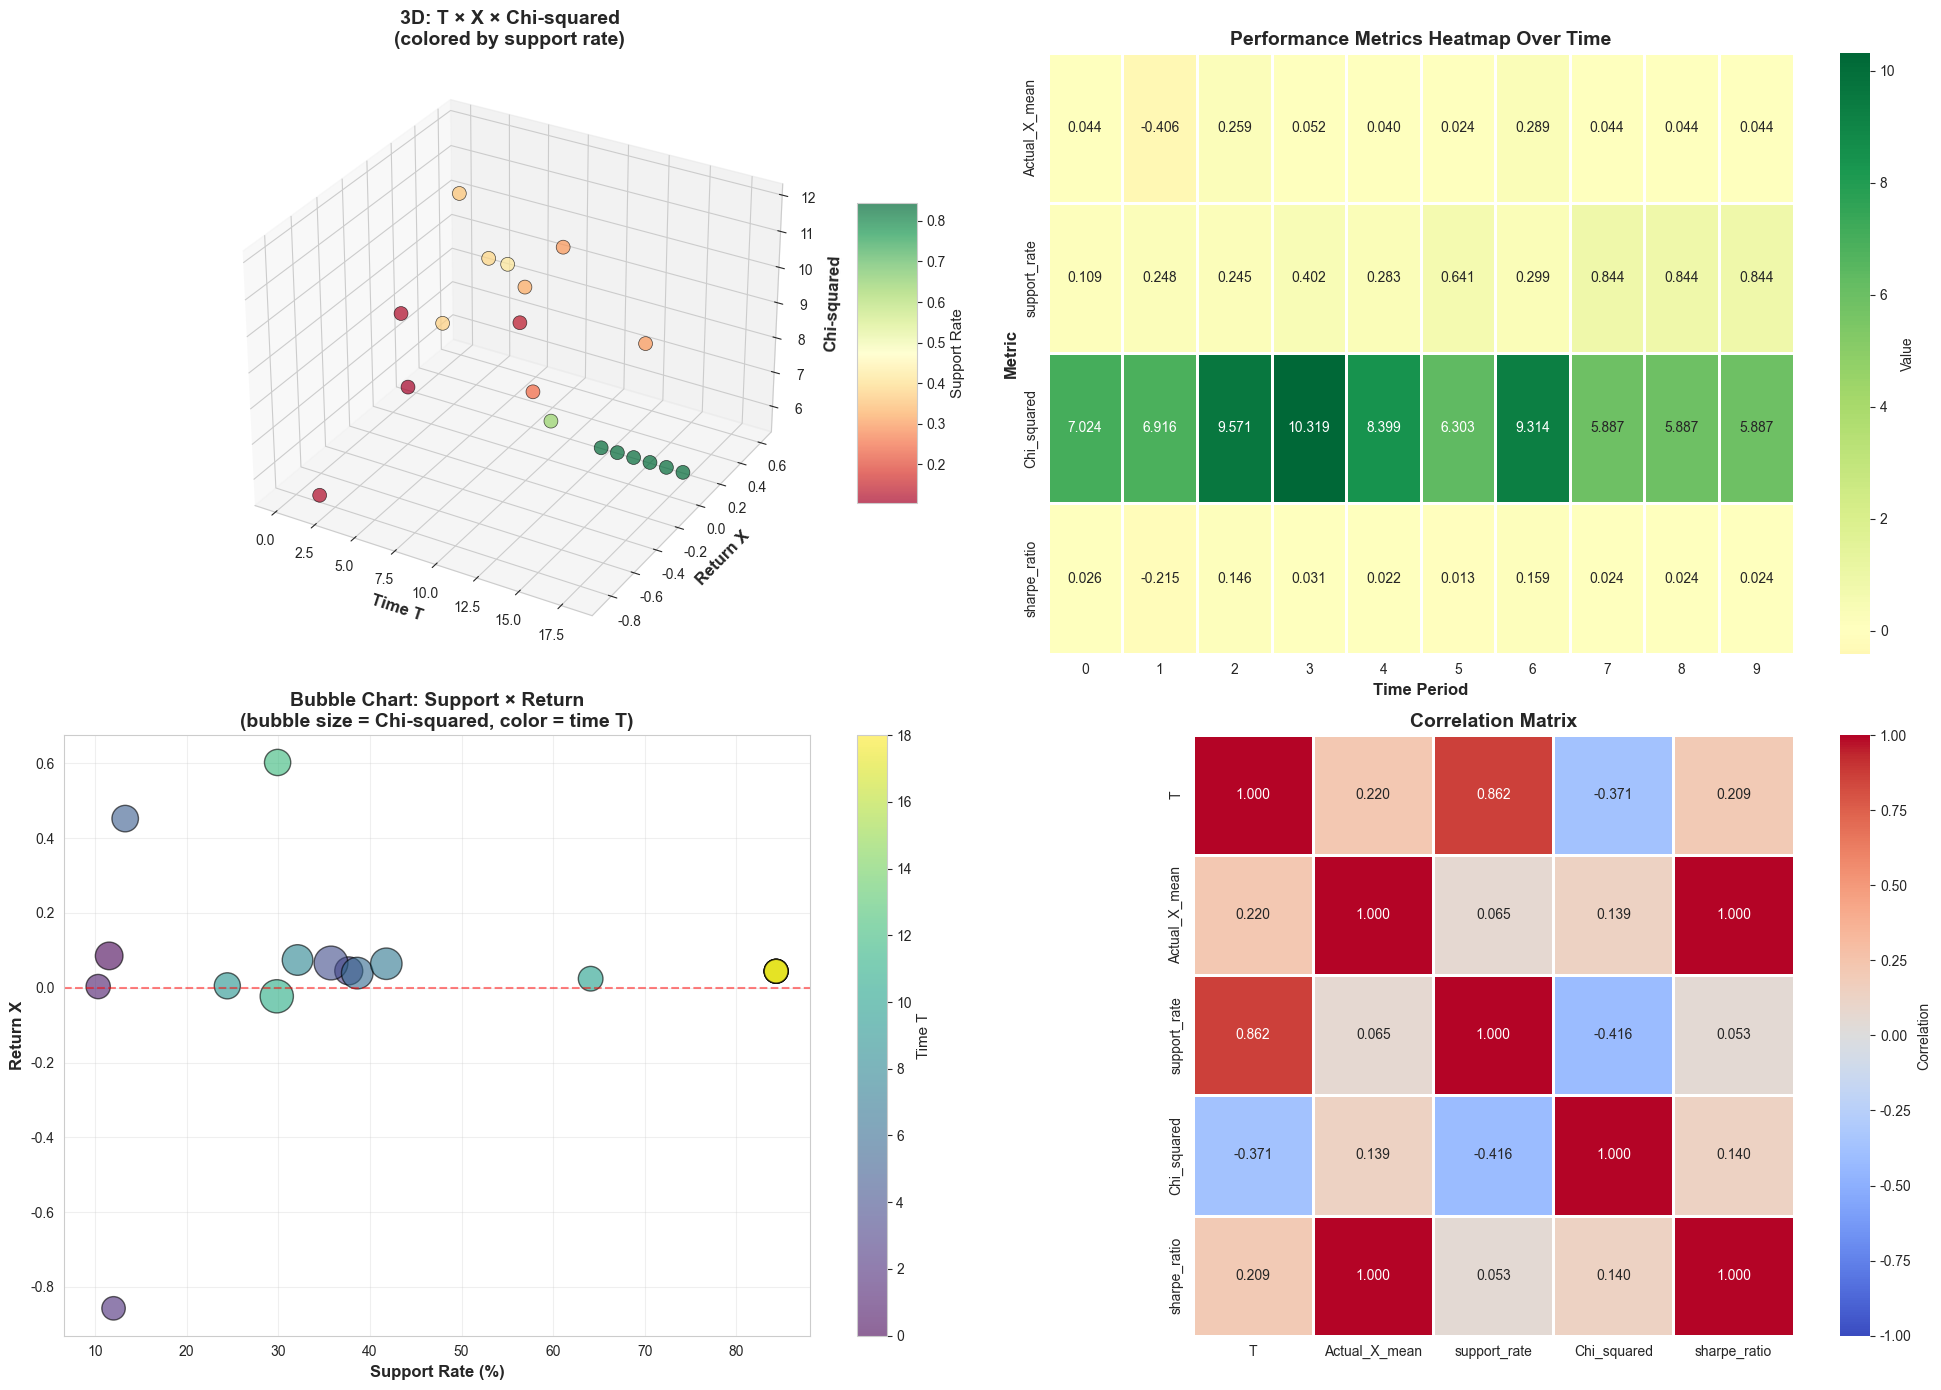

In [8]:
# グラフ4: 多次元可視化
fig = plt.figure(figsize=(20, 14))

# 4-1: 3Dプロット（T, X, Chi-squared）
from mpl_toolkits.mplot3d import Axes3D

ax1 = fig.add_subplot(2, 2, 1, projection='3d')
scatter = ax1.scatter(top_rule_data['T'], 
                     top_rule_data['Actual_X_mean'],
                     top_rule_data['Chi_squared'],
                     c=top_rule_data['support_rate'],
                     cmap='RdYlGn',
                     s=100,
                     alpha=0.7,
                     edgecolors='black',
                     linewidth=0.5)
ax1.set_xlabel('Time T', fontsize=12, fontweight='bold')
ax1.set_ylabel('Return X', fontsize=12, fontweight='bold')
ax1.set_zlabel('Chi-squared', fontsize=12, fontweight='bold')
ax1.set_title('3D: T × X × Chi-squared\n(colored by support rate)', fontsize=14, fontweight='bold')
cbar = plt.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)
cbar.set_label('Support Rate', fontsize=11)

# 4-2: ヒートマップ（時間区間 × パフォーマンス指標）
ax2 = fig.add_subplot(2, 2, 2)

# 時間を区間に分割
n_bins = min(10, len(top_rule_data))
top_rule_data['time_bin'] = pd.cut(top_rule_data['T'], bins=n_bins, labels=False)

# 各区間の統計
heatmap_data = top_rule_data.groupby('time_bin').agg({
    'Actual_X_mean': 'mean',
    'support_rate': 'mean',
    'Chi_squared': 'mean',
    'sharpe_ratio': 'mean'
}).T

sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', center=0, 
            cbar_kws={'label': 'Value'}, ax=ax2, linewidths=1)
ax2.set_xlabel('Time Period', fontsize=12, fontweight='bold')
ax2.set_ylabel('Metric', fontsize=12, fontweight='bold')
ax2.set_title('Performance Metrics Heatmap Over Time', fontsize=14, fontweight='bold')

# 4-3: バブルチャート（X vs Support Rate、バブルサイズ=Chi-squared）
ax3 = fig.add_subplot(2, 2, 3)

scatter2 = ax3.scatter(top_rule_data['support_rate'] * 100,
                      top_rule_data['Actual_X_mean'],
                      s=top_rule_data['Chi_squared'] * 50,
                      c=top_rule_data['T'],
                      cmap='viridis',
                      alpha=0.6,
                      edgecolors='black',
                      linewidth=1)
ax3.axhline(0, color='red', linestyle='--', alpha=0.5)
ax3.set_xlabel('Support Rate (%)', fontsize=12, fontweight='bold')
ax3.set_ylabel('Return X', fontsize=12, fontweight='bold')
ax3.set_title('Bubble Chart: Support × Return\n(bubble size = Chi-squared, color = time T)', 
             fontsize=14, fontweight='bold')
ax3.grid(True, alpha=0.3)
cbar2 = plt.colorbar(scatter2, ax=ax3)
cbar2.set_label('Time T', fontsize=11)

# 4-4: 相関マトリックス
ax4 = fig.add_subplot(2, 2, 4)

corr_data = top_rule_data[['T', 'Actual_X_mean', 'support_rate', 'Chi_squared', 'sharpe_ratio']].corr()
sns.heatmap(corr_data, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            vmin=-1, vmax=1, square=True, linewidths=1, ax=ax4,
            cbar_kws={'label': 'Correlation'})
ax4.set_title('Correlation Matrix', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

## 最終サマリー

In [9]:
print("\n" + "="*80)
print("COMPREHENSIVE RULE ANALYSIS SUMMARY")
print("="*80)
print(f"\nRule: {top_rule['Attr1']} & {top_rule['Attr2']}")
print(f"\n1. TIME SERIES PERFORMANCE (T: 0 to {len(top_rule_data)-1})")
print(f"   Initial Return (T=0): {top_rule_data['Actual_X_mean'].iloc[0]:.4f}")
print(f"   Final Return (T={len(top_rule_data)-1}): {top_rule_data['Actual_X_mean'].iloc[-1]:.4f}")
print(f"   Average Return (X): {top_rule_data['Actual_X_mean'].mean():.4f}")
print(f"   Std Dev: {top_rule_data['Actual_X_mean'].std():.4f}")
print(f"\n2. CUMULATIVE PERFORMANCE")
print(f"   Final Cumulative Return: {top_rule_data['cumulative_return'].iloc[-1]:.4f}")
print(f"   Total Gain/Loss: {(top_rule_data['cumulative_return'].iloc[-1] - 1) * 100:.2f}%")
print(f"   Benchmark Return: {top_rule_data['benchmark_cumulative'].iloc[-1]:.4f}")
print(f"   Outperformance: {(top_rule_data['cumulative_return'].iloc[-1] - top_rule_data['benchmark_cumulative'].iloc[-1]) * 100:.2f}%")
print(f"\n3. RISK METRICS")
print(f"   Average Sharpe Ratio: {top_rule_data['sharpe_ratio'].mean():.4f}")
print(f"   Maximum Drawdown: {drawdown.min():.2f}%")
print(f"   Win Rate: {(top_rule_data['Actual_X_mean'] > 0).sum() / len(top_rule_data) * 100:.2f}%")
print(f"\n4. RULE QUALITY")
print(f"   Average Support Rate: {top_rule_data['support_rate'].mean():.4f} ({top_rule_data['support_rate'].mean()*100:.2f}%)")
print(f"   Average Chi-squared: {top_rule_data['Chi_squared'].mean():.3f}")
print(f"   Significant Periods (Chi² > 3.84): {(top_rule_data['Chi_squared'] > 3.84).sum()} / {len(top_rule_data)}")
print(f"\n5. EXCESS RETURN")
print(f"   Average Excess Return: {top_rule_data['excess_return'].mean():.4f}")
print(f"   Positive Excess Return Rate: {(top_rule_data['excess_return'] > 0).sum() / len(top_rule_data) * 100:.2f}%")
print("="*80)
print("\nAll visualizations complete.")
print("="*80)


COMPREHENSIVE RULE ANALYSIS SUMMARY

Rule: 9434_Stay(t-1) & 6178_Stay(t-1)

1. TIME SERIES PERFORMANCE (T: 0 to 18)
   Initial Return (T=0): 0.0850
   Final Return (T=18): 0.0440
   Average Return (X): 0.0444
   Std Dev: 0.2689

2. CUMULATIVE PERFORMANCE
   Final Cumulative Return: 0.6233
   Total Gain/Loss: -37.67%
   Benchmark Return: 0.9455
   Outperformance: -32.22%

3. RISK METRICS
   Average Sharpe Ratio: 0.0259
   Maximum Drawdown: -85.70%
   Win Rate: 89.47%

4. RULE QUALITY
   Average Support Rate: 0.4671 (46.71%)
   Average Chi-squared: 7.616
   Significant Periods (Chi² > 3.84): 19 / 19

5. EXCESS RETURN
   Average Excess Return: 0.0465
   Positive Excess Return Rate: 89.47%

All visualizations complete.
